In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler

!pip install --upgrade category_encoders
import category_encoders as ce
from sklearn.metrics import classification_report, roc_auc_score
from time import time
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.model_selection import train_test_split
import warnings
import re
import torch
from nltk.stem.porter import PorterStemmer
from pandas.testing import assert_frame_equal
from pandas import testing as tm
## SVD
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Mounted at /content/drive/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


'Tesla P100-PCIE-16GB'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:

%pwd


'/content'

## STEPS FOLLOWED

- Load latest data: songs_charts_final.csv
- Rename columns (added suffix '_n') to avoid conflicts when TF-IDF vectorized column names same as original column names
- Split train,validation,test data including oversampling for balancing
- TFIDF Vectorization of Train data
-------tokenize lyrics column (removed punctuations, stop words,      lemmetization, stemming as part of pre-processing)
-------Convert the tokenized train data into a dataframe
-------Performed SVD for dimensionality reduction
-------Concatenate the tokenized SVD reduced dataframe to the orignal one(reset index).
-------dropping columns not feeding into final models to create main train and test frames
- Repeated same steps as above for TFIDF Vectorization of test data
- Created train data (X_train), train lables, test data (X_test), test labels from these frames
- Label encoing on metadata multi-categorical features (as not numeric and multiple categories and unable to feed into models) for both test and train sets
- Run Logistic Regression model with and without metadata and evaluate

## **Load Data**

In [2]:
data = pd.read_csv("~/w266_project_topmusichits/data/processed/songs_charts_final.csv")
print(data.columns)
print("Length of data:",len(data))

Index(['song_year', 'song_name', 'artist_name', 'album_name', 'genre',
       'lyrics', 'danceability', 'loudness', 'speechiness', 'acousticness',
       'valence', 'tempo', 'num_nonlexvoc', 'star', 'hit'],
      dtype='object')
Length of data: 8546


In [ ]:
# Visualize data
data.head()


,song_year,song_name,artist_name,album_name,genre,lyrics,danceability,loudness,speechiness,acousticness,valence,tempo,num_nonlexvoc,star,hit
0,2000,Tho Dem Wraps,Nelly,Country Grammar,rap,"I boss thru in a Hummer, Murphy the Don, Lizzi...",medium,medium,medium,low,medium,high,low,no,0
1,2000,Beautiful Day,U2,All That You Can't Leave Behind,rock,"The heart is a bloom, shoots up through the st...",low,medium,medium,low,medium,high,low,yes,1
2,2000,Kryptonite,3 Doors Down,The Better Life,rock,"Well, I took a walk around the world to ease m...",low,medium,low,low,medium,low,low,no,1
3,2000,Without You,Lucy Pearl,Lucy Pearl,r&b,Girl you know I want you And I dont know what ...,high,high,high,high,high,low,low,yes,0
4,2000,Ride Wit Me,Nelly,Country Grammar,rap,Where they at? Where they at? Where they at? W...,high,medium,medium,medium,high,low,high,yes,1


In [ ]:
data.columns

Index(['song_year', 'song_name', 'artist_name', 'album_name', 'genre',
       'lyrics', 'danceability', 'loudness', 'speechiness', 'acousticness',
       'valence', 'tempo', 'num_nonlexvoc', 'star', 'hit'],
      dtype='object')

In [ ]:
#Renaming columns to avoid conflict when TF-IDF vectors fetch names gets column names which can be same as existing gcolumns
data.rename(columns = {'genre':'genre_n', 'lyrics':'lyrics_n','danceability':'danceability_n',
                       'loudness':'loudness_n','speechiness':'speechniess_n','acousticness': 'accousticness_n',
                       'valence':'valence_n', 'tempo':'tempo_n', 'star': 'star_n', 'hit':'hit_n'}, inplace = True)
data.columns

Index(['song_year', 'song_name', 'artist_name', 'album_name', 'genre_n',
       'lyrics_n', 'danceability_n', 'loudness_n', 'speechniess_n',
       'accousticness_n', 'valence_n', 'tempo_n', 'num_nonlexvoc', 'star_n',
       'hit_n'],
      dtype='object')

In [ ]:
# Define cutoff date and split train, validation and test sets
split_year = 2017
train_df = data[data['song_year'] < split_year]
test_df = data[data['song_year'] >= split_year]

# Take sample of data FOR TESTING PURPOSES if desired (COMMENT OUT FOR WHOLE DATASET)
# train_df= train_df.iloc[0:100]
# test_df = test_df.iloc[0:50]

# Define features and target
X = train_df.drop(['hit_n'], axis=1)  #keep only the columns that we will use as x's. Right now I am only removing the y from it but we need to remove all the useless columns
y = train_df['hit_n']

# Split  training data into training and validation sets (70% - 30%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42) #Random state is to get reproducible results


# Oversample hits in dataset to have a 3:2 balance of non-hits vs hits
oversample = RandomOverSampler(sampling_strategy=2/3)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
X_val_over, y_val_over = oversample.fit_resample(X_val, y_val)

# Recombine the features and target datasets
train_df_over = pd.concat([X_train_over.reset_index(drop=True), y_train_over.reset_index(drop=True)],axis=1)
val_df_over = pd.concat([X_val_over.reset_index(drop=True), y_val_over.reset_index(drop=True)],axis=1)

In [ ]:
#printing original dimensions to refer back to when merginf TF-IDF frame
#test_df['hit'].value_counts()
print(train_df_over.shape)
print(val_df_over.shape)
print(test_df.shape)

(4411, 15)
(1910, 15)
(3632, 15)


In [ ]:
train_df_over.columns

Index(['song_year', 'song_name', 'artist_name', 'album_name', 'genre_n',
       'lyrics_n', 'danceability_n', 'loudness_n', 'speechniess_n',
       'accousticness_n', 'valence_n', 'tempo_n', 'num_nonlexvoc', 'star_n',
       'hit_n'],
      dtype='object')

In [ ]:
# https://tartarus.org/martin/PorterStemmer/def.txt
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english') #remove stopwords
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split() #remove punctuation, lowercase things and split them on spaces
    words = [porter_stemmer.stem(word) for word in words if word not in stopwords] #removes stopwords and stemming
    words = [lemmatizer.lemmatize(word) for word in words] # lemmatization
    return words


#EXAMPLE TO TEST
stemming_tokenizer('This is a 45 degree an@gle and good greatest heights audible sound enjoyable better, experience 12, corpora #!')
#lemmatizer.lemmatize('better')

#resource: https://jonathansoma.com/lede/foundations/classes/text%20processing/tf-idf/


['45',
 'degre',
 'gle',
 'good',
 'greatest',
 'height',
 'audibl',
 'sound',
 'enjoy',
 'better',
 'experi',
 '12',
 'corpus']

In [ ]:
##TF-IDF Vectorizer on lyrics

#tokenize text column
v = TfidfVectorizer(tokenizer=stemming_tokenizer)
x = v.fit_transform(train_df_over['lyrics_n'])
x_tftest = v.transform(test_df['lyrics_n'])

#get feature names
features_names = v.get_feature_names_out()

In [ ]:
#SVD reduction
def svd_reduction(X_train_counts,X_test,svd_comps, feature_names):
    
    #SVD for dimensionality reduction
    svd = TruncatedSVD(n_components=svd_comps,n_iter=10,random_state=42)
    normalizer = Normalizer(copy=False) #Normalizing SVD results
    lsa = make_pipeline(svd, normalizer) #making pipeline for svd and normalizer

    ## reduced by SVD
    X_svd = lsa.fit_transform(X_train_counts)
    X_test_svd = lsa.transform(X_test)
    print('---------- \nSize of train Vocabulary with preprocessor and SVD is:', X_svd.shape[1])
    
    #explained variance by SVD reduced dimensions
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    
    #extract feature names corresponding to the 1000 SVD components
    best_features = [feature_names[i] for i in svd.components_[0].argsort()[::-1]]
    #print(best_features[:1000])
    
    print(f"Train array: {X_svd.shape}\nTest array: {X_test_svd.shape}")
    
  
    return X_svd, X_test_svd




In [ ]:
svd_components = 1000 #tried 1000, 700, 500, 200 choose 80% variance explained

train_svd, test_svd = svd_reduction(x, x_tftest,
                                    svd_components,
                                   features_names)


train_svd

---------- 
Size of train Vocabulary with preprocessor and SVD is: 1000
Explained variance of the SVD step: 80%
Train array: (4411, 1000)
Test array: (3632, 1000)


array([[ 3.30630919e-01, -2.98622064e-01, -4.33717312e-02, ...,
         4.56674148e-02, -4.10943548e-02, -1.47220377e-02],
       [ 8.42785665e-02, -5.00648797e-02, -3.42311116e-03, ...,
         2.29468113e-03, -4.91871244e-03,  2.36420790e-04],
       [ 2.47882220e-01, -1.44514868e-01, -1.18756612e-02, ...,
         4.47608572e-02,  2.31629517e-02, -3.45037693e-02],
       ...,
       [ 1.98683953e-01, -3.99367977e-02,  2.37646650e-02, ...,
        -1.93706501e-02, -1.64223975e-02,  3.71746828e-04],
       [ 1.90461939e-01, -2.28204727e-02, -1.45104292e-02, ...,
         9.05149515e-03,  1.40127005e-02,  5.50663344e-04],
       [ 3.24609781e-01, -3.11987432e-01, -2.28240828e-02, ...,
         5.18242691e-03, -8.04120060e-03, -3.56460248e-03]])

In [ ]:
# Joining SVD - TF-IDF matrix with metadata


#Convert the SVD train data into a dataframe
df1 = pd.DataFrame(train_svd)

#Concatenate the tokenization dataframe to the orignal one:
res = pd.concat([train_df_over.reset_index(drop=True), df1.reset_index(drop=True)], axis=1)

#dropping columns not feeding into final models
res1 = res.drop(['song_year', 'song_name', 'artist_name', 'album_name', 'lyrics_n'], axis=1)

#check if the two frames merged have the same index
a = train_df_over.index
b = res1.index
tm.assert_index_equal(a,b)

#check
res1.head(7)


,genre_n,danceability_n,loudness_n,speechniess_n,accousticness_n,valence_n,tempo_n,num_nonlexvoc,star_n,hit_n,...,990,991,992,993,994,995,996,997,998,999
0,rap,medium,high,high,high,low,high,low,yes,0,...,-0.032886,-0.006646,0.000595,-0.024851,-0.002602,-0.005884,0.006080,0.045667,-0.041094,-0.014722
1,latin,high,high,medium,low,medium,high,high,yes,1,...,-0.003934,0.008855,-0.008084,-0.008647,-0.012700,0.000497,0.012247,0.002295,-0.004919,0.000236
2,r&b,high,high,high,high,high,medium,low,no,0,...,0.004831,-0.027363,-0.003809,-0.005577,0.033310,0.028548,0.007610,0.044761,0.023163,-0.034504
3,rock,medium,low,low,medium,high,medium,low,yes,0,...,-0.038730,0.012817,0.028073,-0.027539,0.003169,0.001798,-0.018638,0.006502,-0.004882,0.023375
4,pop,high,high,medium,low,high,medium,low,no,0,...,-0.011833,0.010230,-0.005035,-0.008773,-0.019072,-0.003627,0.003553,0.001047,-0.013701,-0.012240
5,rock,low,medium,low,high,high,medium,low,no,0,...,0.016898,-0.005524,0.029358,-0.021600,-0.025266,0.032386,0.027642,-0.002806,-0.032764,0.010638
6,latin,high,high,high,high,high,low,medium,yes,1,...,-0.001323,0.007434,-0.002119,0.005471,-0.010747,0.020437,0.006642,0.002153,0.000185,0.002729


In [ ]:
#similar as above on test data

#Convert the tokenized test data into a dataframe
df2 = pd.DataFrame(test_svd)

#Concatenate the tokenization dataframe to the orignal one:
res_test = pd.concat([test_df.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

#dropping columns not feeding into final models
res2 = res_test.drop(['song_year', 'song_name', 'artist_name', 'album_name', 'lyrics_n'], axis=1)

#check
res2.head(6)


,genre_n,danceability_n,loudness_n,speechniess_n,accousticness_n,valence_n,tempo_n,num_nonlexvoc,star_n,hit_n,...,990,991,992,993,994,995,996,997,998,999
0,r&b,medium,medium,medium,high,high,low,low,no,0,...,-0.014057,0.011977,-0.008453,0.009045,0.006635,-0.015196,0.003493,-0.007291,0.018063,-0.023826
1,rock,low,medium,medium,low,medium,high,low,yes,0,...,0.027442,0.014646,0.009886,0.004197,-0.009281,0.008843,-0.007970,0.018616,-0.002359,-0.007439
2,rap,medium,medium,low,low,low,high,low,no,0,...,-0.000741,0.004835,0.004072,-0.000455,-0.004380,-0.007352,-0.004392,0.005933,-0.001096,-0.001545
3,r&b,medium,medium,high,high,high,low,low,no,0,...,0.009124,-0.010175,-0.021847,-0.005309,-0.014923,-0.005161,0.018491,0.023139,-0.017542,0.004109
4,r&b,low,low,high,high,medium,medium,medium,yes,0,...,-0.014719,-0.005648,-0.011704,0.004378,0.001303,-0.001144,0.026098,-0.014449,-0.009469,-0.010761
5,rap,low,medium,high,low,high,low,low,yes,0,...,-0.013340,0.022857,0.000061,-0.001164,0.002029,0.012676,0.005978,-0.025296,0.009421,-0.001038


In [ ]:
#Creating train data, train lables
res1_train = res1.drop(['hit_n'], axis=1)
res1_trainlabel = res1['hit_n']
res1_train.head()

# Creating test data, test labels
res2_test = res2.drop(['hit_n'], axis=1)
res2_testlabel = res2['hit_n']
res2_test.head()

,genre_n,danceability_n,loudness_n,speechniess_n,accousticness_n,valence_n,tempo_n,num_nonlexvoc,star_n,0,...,990,991,992,993,994,995,996,997,998,999
0,r&b,medium,medium,medium,high,high,low,low,no,0.236919,...,-0.014057,0.011977,-0.008453,0.009045,0.006635,-0.015196,0.003493,-0.007291,0.018063,-0.023826
1,rock,low,medium,medium,low,medium,high,low,yes,0.308658,...,0.027442,0.014646,0.009886,0.004197,-0.009281,0.008843,-0.007970,0.018616,-0.002359,-0.007439
2,rap,medium,medium,low,low,low,high,low,no,0.139970,...,-0.000741,0.004835,0.004072,-0.000455,-0.004380,-0.007352,-0.004392,0.005933,-0.001096,-0.001545
3,r&b,medium,medium,high,high,high,low,low,no,0.478117,...,0.009124,-0.010175,-0.021847,-0.005309,-0.014923,-0.005161,0.018491,0.023139,-0.017542,0.004109
4,r&b,low,low,high,high,medium,medium,medium,yes,0.179618,...,-0.014719,-0.005648,-0.011704,0.004378,0.001303,-0.001144,0.026098,-0.014449,-0.009469,-0.010761


In [ ]:
#Most of our metadata were ordinal features classified as low medium high we decided to use label encoding to reduce the number of dimensions we would have 
#with one hot encoding
#label encoding
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder

le = LabelEncoder()


cols=['genre_n', 'danceability_n', 'loudness_n', 'speechniess_n','accousticness_n', 'valence_n', 'tempo_n', 'num_nonlexvoc', 'star_n' ]

res1_train[cols] = res1_train[cols].apply(LabelEncoder().fit_transform)
res2_test[cols] = res2_test[cols].apply(LabelEncoder().fit_transform)



res1_train.head(5)
res2_test.head(5)
#resource: https://vitalflux.com/labelencoder-example-single-multiple-columns/

,genre_n,danceability_n,loudness_n,speechniess_n,accousticness_n,valence_n,tempo_n,num_nonlexvoc,star_n,0,...,990,991,992,993,994,995,996,997,998,999
0,2,2,2,2,0,0,1,1,0,0.236919,...,-0.014057,0.011977,-0.008453,0.009045,0.006635,-0.015196,0.003493,-0.007291,0.018063,-0.023826
1,4,1,2,2,1,2,0,1,1,0.308658,...,0.027442,0.014646,0.009886,0.004197,-0.009281,0.008843,-0.007970,0.018616,-0.002359,-0.007439
2,3,2,2,1,1,1,0,1,0,0.139970,...,-0.000741,0.004835,0.004072,-0.000455,-0.004380,-0.007352,-0.004392,0.005933,-0.001096,-0.001545
3,2,2,2,0,0,0,1,1,0,0.478117,...,0.009124,-0.010175,-0.021847,-0.005309,-0.014923,-0.005161,0.018491,0.023139,-0.017542,0.004109
4,2,1,1,0,0,2,2,2,1,0.179618,...,-0.014719,-0.005648,-0.011704,0.004378,0.001303,-0.001144,0.026098,-0.014449,-0.009469,-0.010761


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

train_vif = calc_vif(res1_train.iloc[:, 0:9])


X_train = res1_train #rename to X_train
X_test = res2_test #rename to X_test 
train_vif #none of the values > 10 considered a cutoff for severe collinearity

,variables,VIF
0,genre_n,3.381360
1,danceability_n,2.365037
2,loudness_n,2.018611
3,speechniess_n,2.472299
4,accousticness_n,2.223184
5,valence_n,2.239580
6,tempo_n,1.869742
7,num_nonlexvoc,3.987090
8,star_n,1.995832


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


ROC AUC score for oversampled data:  0.6441465381313188
0.13408590308370044
Accuracy of Logistic Regression on test set:   0.729
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      3145
           1       0.25      0.53      0.34       487

    accuracy                           0.73      3632
   macro avg       0.58      0.64      0.59      3632
weighted avg       0.82      0.73      0.76      3632

------------------------------


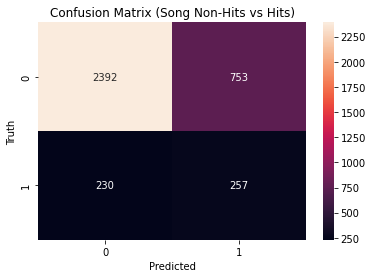

In [ ]:
#LOGISTIC REGRESSION WITH METADATA
from sklearn.svm import SVC
model = LogisticRegression(penalty='l2',max_iter= 1000)


clf = model.fit(X_train, res1['hit_n'])
pred = clf.predict(X_test)
pred_proba = clf.predict_proba(X_test)


print("ROC AUC score for oversampled data: ", roc_auc_score(res2['hit_n'], pred))
print(res2['hit_n'].mean())
# compute the performance measures
score1 = metrics.accuracy_score(res2['hit_n'], pred)
print("Accuracy of Logistic Regression on test set:   %0.3f" % score1)

print(metrics.classification_report(res2['hit_n'], pred))


cm = metrics.confusion_matrix(res2['hit_n'], pred)
sn.heatmap(cm,annot=True,fmt='d')
plt.title("Confusion Matrix (Song Non-Hits vs Hits)")
plt.xlabel("Predicted")
plt.ylabel('Truth')
print('------------------------------')

No handles with labels found to put in legend.


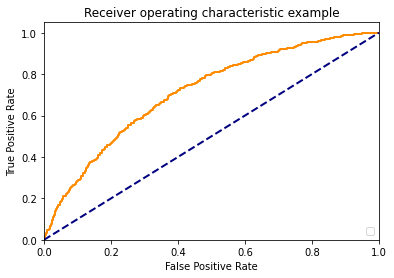

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
plt.figure()
lw = 2
fpr, tpr, _ = roc_curve(res2['hit_n'], pred_proba[:,1])
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw
    #,label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#FEATURE IMPORTANCE
matplotlib.rc('figure', figsize=[5,5])
plt.style.use('ggplot')
importance=model.coef_[0]
importance_abs=abs(importance)
feat_importances = pd.Series(importance_abs, index=X_test.columns)
feat_importances.nlargest(709).plot(kind='barh',title = 'Feature Importance')
print(feat_importances)

# No Metadata

In [ ]:
#dropping metadata columns not feeding into final models
X_train = res1_train.drop(['genre_n',	'danceability_n',	'loudness_n',	'speechniess_n',	'accousticness_n',	'valence_n',	'tempo_n',	'num_nonlexvoc'	,'star_n'], axis=1)
#dropping metadata columns not feeding into final models
X_test = res2_test.drop(['genre_n',	'danceability_n',	'loudness_n',	'speechniess_n',	'accousticness_n',	'valence_n',	'tempo_n',	'num_nonlexvoc'	,'star_n'], axis=1)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.236919,-0.066116,0.001985,-0.047940,0.016245,0.001335,-0.013856,-0.093114,-0.129786,0.008578,...,-0.014057,0.011977,-0.008453,0.009045,0.006635,-0.015196,0.003493,-0.007291,0.018063,-0.023826
1,0.308658,0.022905,-0.038705,-0.206939,-0.118445,-0.028200,0.004099,0.032528,0.066099,-0.032662,...,0.027442,0.014646,0.009886,0.004197,-0.009281,0.008843,-0.007970,0.018616,-0.002359,-0.007439
2,0.139970,-0.065903,0.000306,-0.013556,-0.061928,0.002738,0.032526,-0.061093,0.030547,-0.072495,...,-0.000741,0.004835,0.004072,-0.000455,-0.004380,-0.007352,-0.004392,0.005933,-0.001096,-0.001545
3,0.478117,-0.106507,-0.013898,-0.008662,-0.085688,-0.015716,-0.062208,-0.029984,0.102584,0.044294,...,0.009124,-0.010175,-0.021847,-0.005309,-0.014923,-0.005161,0.018491,0.023139,-0.017542,0.004109
4,0.179618,0.024782,0.094300,-0.022368,-0.012306,0.728188,-0.030123,0.091052,0.080366,-0.060567,...,-0.014719,-0.005648,-0.011704,0.004378,0.001303,-0.001144,0.026098,-0.014449,-0.009469,-0.010761


ROC AUC score for oversampled data:  0.5873277553432161
0.13408590308370044
Accuracy of Logistic Regression on test set:   0.724
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3145
           1       0.22      0.40      0.28       487

    accuracy                           0.72      3632
   macro avg       0.55      0.59      0.55      3632
weighted avg       0.80      0.72      0.76      3632



Text(33.0, 0.5, 'Truth')

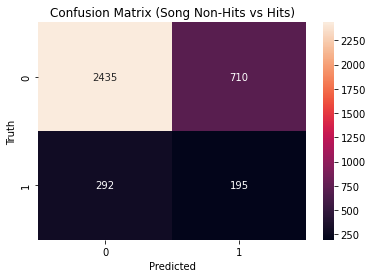

In [ ]:
#LOGISTIC REGRESSION WITHOUT METADATA
from sklearn.svm import SVC
model = LogisticRegression(penalty='l2',max_iter= 1000)


clf = model.fit(X_train, res1['hit_n'])
pred = clf.predict(X_test)
pred_proba = clf.predict_proba(X_test)


print("ROC AUC score for oversampled data: ", roc_auc_score(res2['hit_n'], pred))
print(res2['hit_n'].mean())
# compute the performance measures
score1 = metrics.accuracy_score(res2['hit_n'], pred)
print("Accuracy of Logistic Regression on test set:   %0.3f" % score1)

print(metrics.classification_report(res2['hit_n'], pred))


cm = metrics.confusion_matrix(res2['hit_n'], pred)
sn.heatmap(cm,annot=True,fmt='d')
plt.title("Confusion Matrix (Song Non-Hits vs Hits)")
plt.xlabel("Predicted")
plt.ylabel('Truth')

No handles with labels found to put in legend.


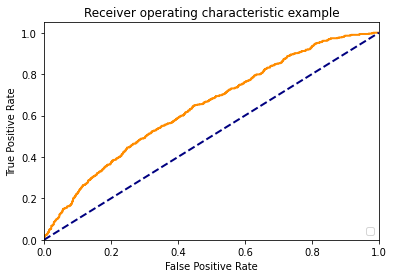

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
plt.figure()
lw = 2
fpr, tpr, _ = roc_curve(res2['hit_n'], pred_proba[:,1])
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw
    #,label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()